In [6]:
from helper_code import *
from team_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
codes = pd.read_csv("dataset/codes.csv")

In [7]:
# look at dataset directory and extract the label dataframe for each dataset

directories = glob("dataset/*/", recursive = True)
for d in direcories:
    dataset = d.split("/")[-2]
    header_files, recording_files = find_challenge_files(d)
    num_recordings = len(recording_files)

    if not num_recordings:
        raise Exception('No data was provided.')

    # Extract the classes from the dataset.

    classes = set()
    for header_file in header_files:
        header = load_header(header_file)
        classes |= set(get_labels(header))
    if all(is_integer(x) for x in classes):
        classes = sorted(classes, key=lambda x: int(x)) # Sort classes numerically if numbers.
    else:
        classes = sorted(classes) # Sort classes alphanumerically if not numbers.
    num_classes = len(classes)

    # Extract the features and labels from the dataset.
    
    print('Extracting features and labels for %s'%dataset)
    print("\n")
    data = np.zeros((num_recordings, 14), dtype=np.float32) # 14 features: one feature for each lead, one feature for age, and one feature for sex
    labels = np.zeros((num_recordings, num_classes), dtype=np.bool_) # One-hot encoding of classes
    for i in range(num_recordings):
        print('    {}/{}...'.format(i+1, num_recordings),end="\r")

        # Load header and recording.
        header = load_header(header_files[i])
        recording = load_recording(recording_files[i])

        # Get age, sex and root mean square of the leads.
        age, sex, rms = get_features(header, recording, twelve_leads)
        data[i, 0:12] = rms
        data[i, 12] = age
        data[i, 13] = sex

        current_labels = get_labels(header)
        for label in current_labels:
            if label in classes:
                j = classes.index(label)
                labels[i, j] = 1

    df = pd.DataFrame(labels,columns = classes)
    df["headers"] = header_files
    df["leads"] = recording_files
    df.to_csv("dataset/%s.csv"%dataset,index=False)

Extracting features and labels for WFDB_CPSC2018


Extracting features and labels for WFDB_CPSC2018_2


Extracting features and labels for WFDB_PTB


Extracting features and labels for WFDB_StPetersburg


Extracting features and labels for WFDB_ChapmanShaoxing


Extracting features and labels for WFDB_Ga


Extracting features and labels for WFDB_PTBXL


Extracting features and labels for WFDB_Ningbo




In [281]:
ecg_num = -1
header = load_header(header_files[ecg_num])
leads = load_recording(recording_files[i])
# ecg_plot.plot(leads/np.max(leads))

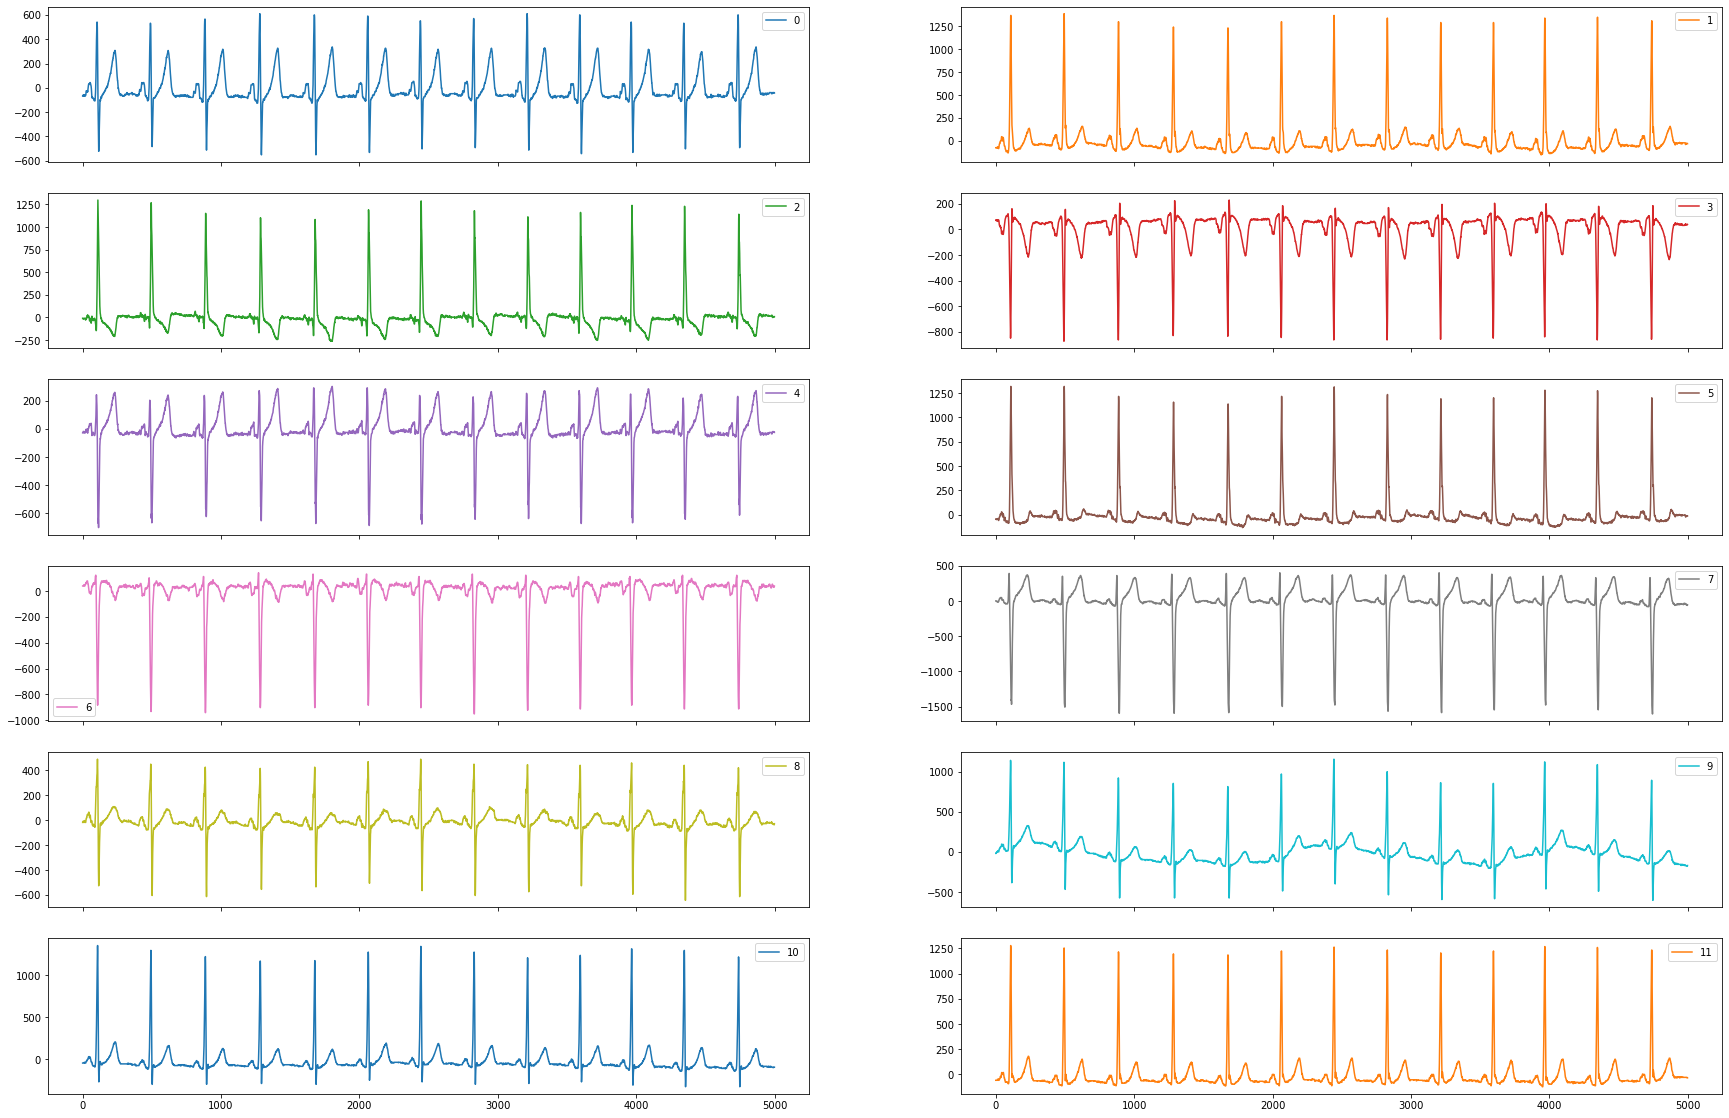

In [230]:
fig = pd.DataFrame(leads).T.plot.line(subplots = True,layout=(6,2), figsize=(30,20))